In [1]:
# JAX imports
from jax import jit, vmap
from jax.config import config
config.update("jax_enable_x64", True)
from jax.lax import fori_loop
import jax.numpy as jnp

In [2]:
import matplotlib.pyplot as plt
%matplotlib inline
from numba import njit
import numpy as np
from numpy.linalg import norm
from scipy.interpolate import InterpolatedUnivariateSpline, RectBivariateSpline
from scipy.special import sph_harm, spherical_jn
from sympy.physics.quantum.cg import CG
import vegas

In [3]:
# Imports from scripts
from scripts.integration import momentum_mesh, unattach_weights_from_matrix
from scripts.potentials import Potential
from scripts.srg import load_srg_transformation
from scripts.tools import convert_l_to_string, coupled_channel, replace_periods

In [4]:
class SingleParticleState:
    """
    Single-particle state class. Packs together the following single-particle
    quantum numbers into one object.
    
    Parameters
    ----------
    n : int
        Principal quantum number n = 1, 2, ...
    l : int
        Orbital angular momentum l = 0, 1, ...
    j : float
        Total angular momentum j = 1/2, 3/2, ...
    m_j : float
        Total angular momentum projection m_j = -j, -j+1, ..., j.
    m_t : float
        Isospin projection m_t = 1/2 or -1/2.
    
    """
    
    
    def __init__(self, n, l, j, m_j, m_t):
        
        # Check if m_j is valid
        if abs(m_j) > j:
            raise RuntimeError("m_j is not valid.")
            
        # Check that |m_t| = 1/2
        if abs(m_t) != 1/2:
            raise RuntimeError("m_t is not valid.")
            
        self.n = n
        self.l = l
        self.j = j
        self.m_j = m_j
        self.m_t = m_t
        
        if m_t == 1/2:
            self.nucleon = 'proton'
        elif m_t == -1/2:
            self.nucleon = 'neutron'
        
        
    def __eq__(self, sp_state):

        if (
            self.n == sp_state.n and self.l == sp_state.l
            and self.j == sp_state.j and self.m_j == sp_state.m_j
            and self.m_t == sp_state.m_t
        ):
            
            return True
        
        else:
            
            return False
        
        
    def __str__(self):
        
        # Spectroscopic notation of orbital angular momentum
        l_str = convert_l_to_string(self.l)  # E.g., 's', 'p', 'd', ...
        
        # Display j subscript as a fraction
        numerator = 2*int(self.j) + 1
        denominator = 2

        return fr"${self.n}{l_str}_{{{numerator}/{denominator}}}$"

In [5]:
class WoodsSaxon:
    """
    Woods-Saxon orbitals class. Handles the radial wave functions associated
    with the Woods-Saxon potential from the subroutine in woodsaxon.f90. Outputs
    radial functions in coordinate and momentum space.
    
    Parameters
    ----------
    nucleus_name : str
        Name of the nucleus (e.g., 'O16', 'Ca40', etc.)
    Z : int
        Proton number of the nucleus.
    N : int
        Neutron number of the nucleus.
    run_woods_saxon : bool, optional
        Option to run the Woods-Saxon subroutine to generate orbital files.
    n_max : int, optional
        Maximum principal quantum number where n = 1, 2, ..., n_max.
    l_max : int, optional
        Maximum orbital angular momentum where l = 0, 1, ..., l_max.
    rmax : float, optional
        Maximum r for orbital tables.
    ntab : int, optional
        Number of points for orbital tables.
        
    """
    
    
    def __init__(self, nucleus_name, Z, N, cg_table, rmax=40, ntab=2000,
                 kmax=10.0, kmid=2.0, ntot=120, com_correction=False):
        
        # Set instance attributes
        self.woods_saxon_directory = f"../data/woods_saxon/{nucleus_name}/"
        self.cg_table = cg_table
        self.A = int(Z + N)

        # Order single-particle states with lowest energy first
        self.order_sp_states(Z, N)
        
        # Organize wave functions in dictionary
        self.sp_wfs = {}
        for sp_state in self.sp_states:
            
            # Wave functions are independent of m_j, so fix m_j=j
            if sp_state.m_j == sp_state.j:
                
                file_name = self.get_orbital_file_name(sp_state)
 
                data = np.loadtxt(self.woods_saxon_directory + file_name)
                
                # Use n, l, j, m_t as the key
                key = (sp_state.n, sp_state.l, sp_state.j, sp_state.m_t)
                self.sp_wfs[key] = data[:, 1]
                
        # r_array and dr are the same for every s.p. state
        self.r_array = data[:, 0]
        self.dr = max(self.r_array) / len(self.r_array)
        
        # Interpolate occupied s.p. wave functions w.r.t. momentum k
        self.interpolate_wavefunctions(kmax, kmid, ntot, com_correction)
        
        
    def get_orbital_file_name(self, sp_state):
        """Returns the file name of the orbital."""
            
        # Proton
        if sp_state.m_t == 1/2:
            file_name = (f"p.n{int(sp_state.n-1)}.l{int(sp_state.l)}"
                          f".j{int(2*sp_state.j)}.orb")
        # Neutron
        elif sp_state.m_t == -1/2:
            file_name = (f"n.n{int(sp_state.n-1)}.l{int(sp_state.l)}"
                          f".j{int(2*sp_state.j)}.orb")
        # # TESTING
        # file_name = f"n{int(sp_state.n-1)}.l{int(sp_state.l)}.j{int(2*sp_state.j)}.orb"
            
        return file_name
        
        
    def order_sp_states(self, Z, N):
        """Keep track of all s.p. states and occupied s.p. states"""

        self.sp_states = []  # All single-particle states
        self.occupied_states = []  # Occupied single-particle states < E_F
        proton_count = 0
        neutron_count = 0
        
        # File with details of the orbitals
        ws_file = self.woods_saxon_directory + "ws_log"
    
        # Order single-particle states using the ws_log file
        with open(ws_file, 'r') as f:
            for line in f:
                unit = line.strip().split()
                
                # Protons
                if len(unit) > 0 and unit[0] == '1':

                    j = int(unit[3])/2
                    for m_j in np.arange(-j, j+1, 1):
                        sp_state = SingleParticleState(
                            int(unit[1])+1, int(unit[2]), j, m_j, 1/2
                        )  # n, l, j, m_j, m_t
                    
                        self.sp_states.append(sp_state)
                    
                        if proton_count < Z:
                            self.occupied_states.append(sp_state)
                            # Add up filled proton states
                            proton_count += 1
                    
                
                # Neutrons
                elif len(unit) > 0 and unit[0] == '2':

                    j = int(unit[3])/2
                    for m_j in np.arange(-j, j+1, 1):
                        sp_state = SingleParticleState(
                            int(unit[1])+1, int(unit[2]), j, m_j, -1/2
                        )  # n, l, j, m_j, m_t
                    
                        self.sp_states.append(sp_state)
                    
                        if neutron_count < N:
                            self.occupied_states.append(sp_state)
                            # Add up filled neutron states
                            neutron_count += 1


    def get_wf_rspace(
            self, sp_state, print_normalization=False, com_correction=False
    ):
        """Single-particle wave function in coordinate space."""
        
        # n, l, j, m_t
        key = (sp_state.n, sp_state.l, sp_state.j, sp_state.m_t) 
        u_array = self.sp_wfs[key]

        # Normalization: \int dr |u(r)|^2 = 1
        if print_normalization:
            normalization = np.sum(self.dr * u_array ** 2)
            print(f"Coordinate space normalization = {normalization}.")
        
        # Return r and [(A-1)/A]^(1/4) * u(\sqrt[(A-1)/A] * r)
        if com_correction:
            
            u_func = InterpolatedUnivariateSpline(self.r_array, u_array)
            A = self.A
            # u_com_array = (((A-1)/A) ** (1/4)
            #                 * u_func(np.sqrt((A-1)/A) * self.r_array))
            # # TESTING
            # u_com_array = ((A/(A-1)) ** (1/4)
            #                * u_func(np.sqrt(A/(A-1)) * self.r_array))
            scaling = ((A-1)/A) ** (1/4)
            u_com_array = np.sqrt(scaling) * u_func(scaling * self.r_array)

            return self.r_array, u_com_array
        
        # Return r and u(r)
        else:

            return self.r_array, u_array
    
    
    def fourier_transformation(self, l, r_array, k_array):
        """Fourier transformation matrix for given orbital angular momentum."""
        
        # r_array column vectors and k_array row vectors where both grids are
        # n x m matrices
        r_cols, k_rows = np.meshgrid(r_array, k_array)
        
        # Transformation matrix with shape n x m, where m is the length of
        # r_array and n is the length of the k_array
        M = 1j ** (-l) * np.sqrt(2/np.pi) * self.dr * r_cols * spherical_jn(
            l, k_rows*r_cols
        )
        
        return M
    
    
    def get_wf_kspace(
            self, sp_state, kmax, kmid, ntot, print_normalization=False,
            interpolate=False, com_correction=False
    ):
        """Single-particle wave function in momentum space."""
    
        # Set momentum mesh with more points at low momentum
        k_array, k_weights = momentum_mesh(kmax, kmid, ntot)
    
        # Get coordinate-space s.p. wave function
        r_array, u_array = self.get_wf_rspace(sp_state,
                                              com_correction=com_correction)

        # Fourier-transform the wave function to momentum space
        phi_array = (self.fourier_transformation(sp_state.l, r_array, k_array)
                     @ u_array)
    
        # Normalization: \int dk k^2 |\phi(k)|^2 = 1
        if print_normalization:
            normalization = np.sum(k_weights * k_array ** 2
                                   * abs(phi_array) ** 2)
            print(f"Momentum space normalization = {normalization}.")
            
        # Interpolate and return function?
        if interpolate:
            
            if sp_state.l % 2 == 0:  # Even l
                
                phi_func = InterpolatedUnivariateSpline(k_array, phi_array.real)
                
            else:  # Odd l
            
                phi_func = InterpolatedUnivariateSpline(k_array, phi_array.imag)
                
            return phi_func
        
        # Otherwise return momentum, weights, and \phi(k)
        else:
            return k_array, k_weights, phi_array
        
        
    def interpolate_wavefunctions(self, kmax, kmid, ntot, com_correction=False):
        """Create dictionary of \phi(k) interpolated functions where the key
        is the single-particle state.
        """
        
        # Organize interpolated wave functions in dictionary with s.p. quantum
        # numbers as the key
        self.phi_functions = {}
        
        for sp_state in self.occupied_states:
            
            key = (sp_state.n, sp_state.l, sp_state.j, sp_state.m_t)
            self.phi_functions[key] = self.get_wf_kspace(
                sp_state, kmax, kmid, ntot, interpolate=True,
                com_correction=com_correction
            )
            
    
    def psi(self, sp_state, k, theta, phi, sigma, tau):
        """Single-particle wave function \psi_\alpha(k_vector; \sigma, \tau)."""

        # Calculate \phi_\alpha(k)
        key = (sp_state.n, sp_state.l, sp_state.j, sp_state.m_t)
        if sp_state.l % 2 == 0:  # Even l
            phi_sp_wf = self.phi_functions[key](k)
        else:  # Odd l needs factor of i^-l
            phi_sp_wf = 1j ** (-sp_state.l) * self.phi_functions[key](k)
    
        # Calculate spinor spherical harmonic
        Y_jml = self.spinor_spherical_harmonic(sp_state.l, sp_state.j,
                                               sp_state.m_j, theta, phi, sigma)
    
        # Isospinor indexed by \tau \chi_{m_t}(\tau)
        chi_tau = kronecker_delta(tau, sp_state.m_t)

        return phi_sp_wf * Y_jml * chi_tau
    

    def spinor_spherical_harmonic(self, l, j, m_j, theta, phi, sigma):
        """Spinor spherical harmonic for a s.p. state described by the quantum
        numbers j, m_j, l, and s=1/2.
        """
        
        # Spinor indexed by \sigma \eta_{m_s}^(\sigma) = \delta_{m_s, \sigma}
        m_s = sigma
    
        # m_l must be fixed since m_j and m_s are determined
        m_l = m_j - m_s
        
        # Check that |m_l| <= l
        if np.abs(m_l) <= l:
        
            # Clebsch-Gordan coefficient for l-s coupling
            cg = self.cg_table[(l, m_l, 1/2, m_s, j, m_j)]
        
            # Spherical harmonic
            Y_lm = sph_harm(m_l, l, phi, theta)
            
            return cg * Y_lm
        
        else:
            
            return 0+0j

In [6]:
def compute_clebsch_gordan_table(j_max):
    """
    Calculate Clebsch-Gordan coefficients for combinations of j and m_j up
    to j_max.
    
    Parameters
    ----------
    j_max : int
        Maximum j value for j_1, j_2, and j_3. This also constrains m_j.
    
    Returns
    -------
    cg_table : dict
        Table of Clebsch-Gordan coefficients <j_1 m_j_1 j_2 m_j_2|j_3 m_j_3>
        for each combination of angular momenta.
        
    """
        
    cg_table = {}
        
    j_array = np.arange(0, j_max+1/2, 1/2)
    
    for j_1 in j_array:
        for j_2 in j_array:
            j_3_array = np.arange(abs(j_1-j_2), j_1+j_2+1)
            for j_3 in j_3_array:
                for m_1 in np.arange(-j_1, j_1+1, 1):
                    for m_2 in np.arange(-j_2, j_2+1, 1):
                        
                        m_3 = m_1 + m_2
                        
                        if abs(m_3) <= j_3:
                            cg_table[(j_1, m_1, j_2, m_2, j_3, m_3)] = float(
                                CG(j_1, m_1, j_2, m_2, j_3, m_3).doit()
                            )
                            
    print(f"Done calculating Clebsch-Gordan table up to j_max = {j_max}.")
                                
    return cg_table

In [7]:
@njit
def kronecker_delta(x, y):
    """Kronecker \delta function: \delta_{x,y}."""
    
    return int(x == y)

In [8]:
cg_table = compute_clebsch_gordan_table(3)

Done calculating Clebsch-Gordan table up to j_max = 3.


In [9]:
ws = WoodsSaxon('O16', 8, 8, cg_table)

In [10]:
sp_state = SingleParticleState(1, 0, 1/2, 1/2, 1/2)

k_array, k_weights, phi_array = ws.get_wf_kspace(sp_state, 10.0, 2.0, 120,
                                                 print_normalization=True)

Momentum space normalization = 0.9999999999448075.


In [11]:
k_fine_array = jnp.arange(0.01, 10.0, 0.01)
phi_fine_array = jnp.interp(k_fine_array, k_array, phi_array)

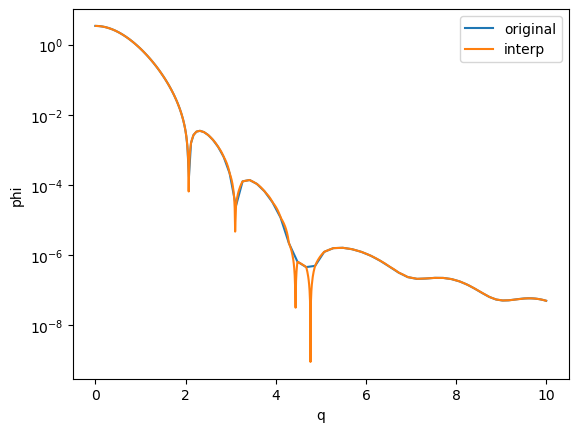

In [12]:
plt.semilogy(k_array, np.abs(phi_array), label='original')
plt.semilogy(k_fine_array, jnp.abs(phi_fine_array), label='interp')
plt.xlabel('q')
plt.ylabel('phi')
plt.legend()
plt.show()

In [13]:
def interpolate_delta_U_python(channel, potential, generator, lamb):

    # Get momentum mesh
    kmax, kmid, ntot = potential.kmax, potential.kmid, potential.ntot
    k_array, k_weights = momentum_mesh(kmax, kmid, ntot)
    
    # Get SRG transformation with integration weights [unitless]
    U_matrix_weights = load_srg_transformation(potential, generator, lamb)
    
    # Get SRG transformation with integration weights [unitless]
    I_matrix_weights = np.eye(len(U_matrix_weights))

    # Calculate \delta U = U - I
    delU_matrix_weights = U_matrix_weights - I_matrix_weights

    delU_matrix = unattach_weights_from_matrix(k_array, k_weights,
                                               delU_matrix_weights)
        
    # Interpolate \delta U(k, k')
    delU_func = RectBivariateSpline(k_array, k_array, delU_matrix)

    return delU_func

In [14]:
kvnn, channel, kmax, kmid, ntot = 6, '1S0', 15.0, 3.0, 120
potential = Potential(kvnn, channel, kmax, kmid, ntot)
generator = 'Wegner'
lamb = 1.5

In [15]:
delU_func_python = interpolate_delta_U_python(channel, potential, generator,
                                              lamb)

In [16]:
k_points = np.arange(1.0, 5.0, 1.0)
k_grid, kp_grid = np.meshgrid(k_points, k_points, indexing='ij')
print(delU_func_python.ev(k_grid, kp_grid))

[[-0.01518466 -0.01101201 -0.0485835  -0.0295862 ]
 [-0.01679054 -0.01452841 -0.05496413 -0.02613794]
 [ 0.02318212  0.03331396 -0.02753839 -0.04082214]
 [ 0.02236797  0.02354017  0.03095263 -0.04256255]]


In [21]:
from scipy.ndimage import map_coordinates

def get_delta_U(channel, potential, generator, lamb):
    
    # Get momentum mesh
    kmax, kmid, ntot = potential.kmax, potential.kmid, potential.ntot
    k_array, k_weights = momentum_mesh(kmax, kmid, ntot)
    
    # Get SRG transformation with integration weights [unitless]
    U_matrix_weights = load_srg_transformation(potential, generator, lamb)
    
    # Get SRG transformation with integration weights [unitless]
    I_matrix_weights = np.eye(len(U_matrix_weights))

    # Calculate \delta U = U - I
    delU_matrix_weights = U_matrix_weights - I_matrix_weights

    delU_matrix = unattach_weights_from_matrix(k_array, k_weights,
                                               delU_matrix_weights)
    
    return delU_matrix

def evaluate_delta_U(k, kp, delU_matrix):

    # Interpolate \delta U(k, k')
    delU = map_coordinates(delU_matrix, [[k], [kp]], order=3)

    return delU

In [22]:
delta_U = get_delta_U(channel, potential, generator, lamb)

In [25]:
# k, kp = 1.0, 1.0
# k, kp = 1.0, 2.0
k, kp = 4.0, 4.0

print(evaluate_delta_U(k, kp, delta_U))

[-0.02399424]
